# 图注意力网络 GAT

- PyG: [conv.GATConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch-geometric-nn-conv-gatconv)
- arXiv: [Graph Attention Networks](https://arxiv.org/abs/1710.10903)
- GitHub: [PetarV-/GAT](https://github.com/PetarV-/GAT)

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

import util

In [2]:
CORA_PATH = './data'
EDGE_FILE = 'cora.cites'
FEAT_FILE = 'cora.content'

## 1. 加载 Cora 数据集

这一次，我们用自定义的 `util` 库加载 Cora 数据集。

In [3]:
# 获取文件路径
edge_path = util.gen_abspath(CORA_PATH, EDGE_FILE)
feat_path = util.gen_abspath(CORA_PATH, FEAT_FILE)

# 加载图数据
edge_list, feat_dict, label_dict, label_map = \
    util.load_cora(edge_path, feat_path)
cora_data = util.create_pyg_cora_data(edge_list, feat_dict, label_dict)

# 随机分割训练集、验证集和测试集
cora_dataset = util.random_split_cora_data(data=cora_data,
                                      train_rate=0.6,
                                      val_rate=0.2)
cora_dataset

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

## 2. 训练 GAT 模型

In [4]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.8)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

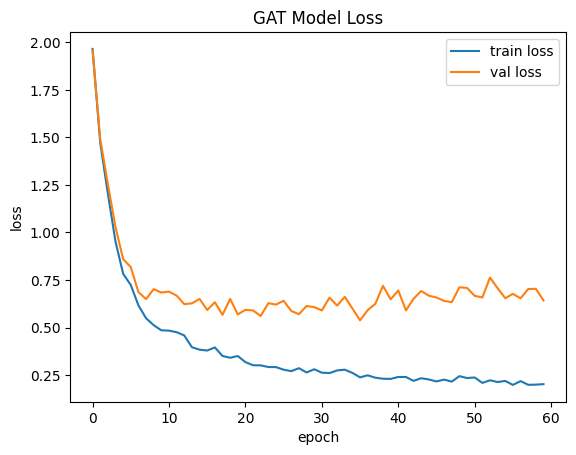

In [5]:
# 模型初始化
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=cora_dataset.num_node_features,
            hidden_channels=16,
            out_channels=len({e.item() for e in cora_dataset.y}),
            heads=8).to(device)
data = cora_dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01,
                             weight_decay=5e-4)

# 训练
model, train_loss_list, val_loss_list = util.train(model=model,
                                                   optimizer=optimizer,
                                                   data=data,
                                                   num_epoch=60)
# loss 图像
util.plot_loss(train_loss_list, val_loss_list, title='GAT Model Loss')

## 3. 预测与评估

In [6]:
# 用测试集做推理
out = model(data)
print(f'Embedding.shape of test dataset: {out[data.test_mask].shape}')
print(f'Top 5 Embedding of test dataset: {out[data.test_mask][:5]}')

# 标签到标签值的映射
reversed_label_map = {v:k for k, v in label_map.items()}

# 评估指标
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = correct.item() / data.test_mask.sum().item()
print(f'Accuracy: {acc:.4f}')

# 打印前 5 个预测标签和真实标签
top_5_pred_label = [reversed_label_map[e.item()] for e in pred[data.test_mask][:5]]
top_5_true_label = [reversed_label_map[e.item()] for e in data.y[data.test_mask][:5]]
print(f'Top 5 pred label of test dataset: {top_5_pred_label}')
print(f'Top 5 true label of test dataset: {top_5_true_label}')

Embedding.shape of test dataset: torch.Size([543, 7])
Top 5 Embedding of test dataset: tensor([[-8.5364e+00, -5.4823e+00, -7.9870e-01, -6.0869e-01, -9.0408e+00,
         -7.7531e+00, -6.7972e+00],
        [-6.4265e+00, -3.7387e+00, -6.1671e+00, -5.3537e+00, -5.4460e+00,
         -6.8961e+00, -3.8279e-02],
        [-3.2391e-01, -4.7610e+00, -6.1687e+00, -1.6746e+00, -2.8031e+00,
         -4.5417e+00, -4.9093e+00],
        [-6.6076e+00, -1.3989e+01, -6.6868e+00, -1.1344e+01, -1.0584e+01,
         -2.6465e-03, -1.1776e+01],
        [-1.3015e+01, -1.5020e+01, -3.1049e-04, -1.8051e+01, -1.5245e+01,
         -1.3919e+01, -8.0895e+00]], grad_fn=<SliceBackward0>)
Accuracy: 0.8637
Top 5 pred label of test dataset: ['Probabilistic_Methods', 'Case_Based', 'Neural_Networks', 'Genetic_Algorithms', 'Reinforcement_Learning']
Top 5 true label of test dataset: ['Probabilistic_Methods', 'Case_Based', 'Neural_Networks', 'Genetic_Algorithms', 'Reinforcement_Learning']


说实话，这个 Accuracy 效果一般。如果要继续优化，感觉需要从抽样入手。